In [1]:
import pfMech as sim
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import json, os
import powercalc as pc
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:
os.chdir('/Users/cwagner2/Work/projects/malaria/pf-longitudinal-antigens/immunity-sims/pf-tent/') 

In [3]:
y=5
a = [10,10,10,10,10,10]
w = [0,1/5,1/5,1/5,1/5,1/5]
eir = 90
n_people = 100

In [4]:
fever = np.load("data/fever.npy")
breaks = np.load("data/breaks.npy")
fever_arr = sim.get_fever_arr(eir,fever,breaks)
pmatrix, imatrix,smatrix, malaria,bites = sim.simulate_person(y,eir,a,w,fever_arr)
visits = pc.get_visits(malaria,28,y)
all_parasites, all_immunity, all_strains, all_malaria,all_bites = sim.simulate_cohort(n_people,y,eir,a,w)

/Users/cwagner2/Work/projects/malaria/pf-longitudinal-antigens/immunity-sims/pf-tent/code/pfMech.py:169: RuntimeWarning: divide by zero encountered in reciprocal
  r = ((r0-rend)/(c/np.tan(np.pi/2*imm)**b+1)) + rend


In [5]:
def get_times_since(loci, allele, pmatrix, visits):
    '''
    Returns start times for all infections.
    Returns end times for all infections.
    Returns the time since exposure for all infections.
    Values are for measured timepoints.
    '''
    visits = np.asarray(visits)
    values = pmatrix[loci,allele,visits]
    signed = np.sign(values)
    shifted = np.roll(signed,1)
    test = signed - shifted
    test[0] = signed[0]
    starts = visits[test==1]
    endlocs = np.where(test==-1)[0]
    ends = visits[endlocs-1]
    if len(starts) > len(ends):
        ends = np.append(ends,visits[-1])
    sinceExp = [start-last for start,last in zip(starts[1:],ends)]
    sinceExp = np.concatenate(([np.nan],sinceExp))
    return starts, ends, sinceExp

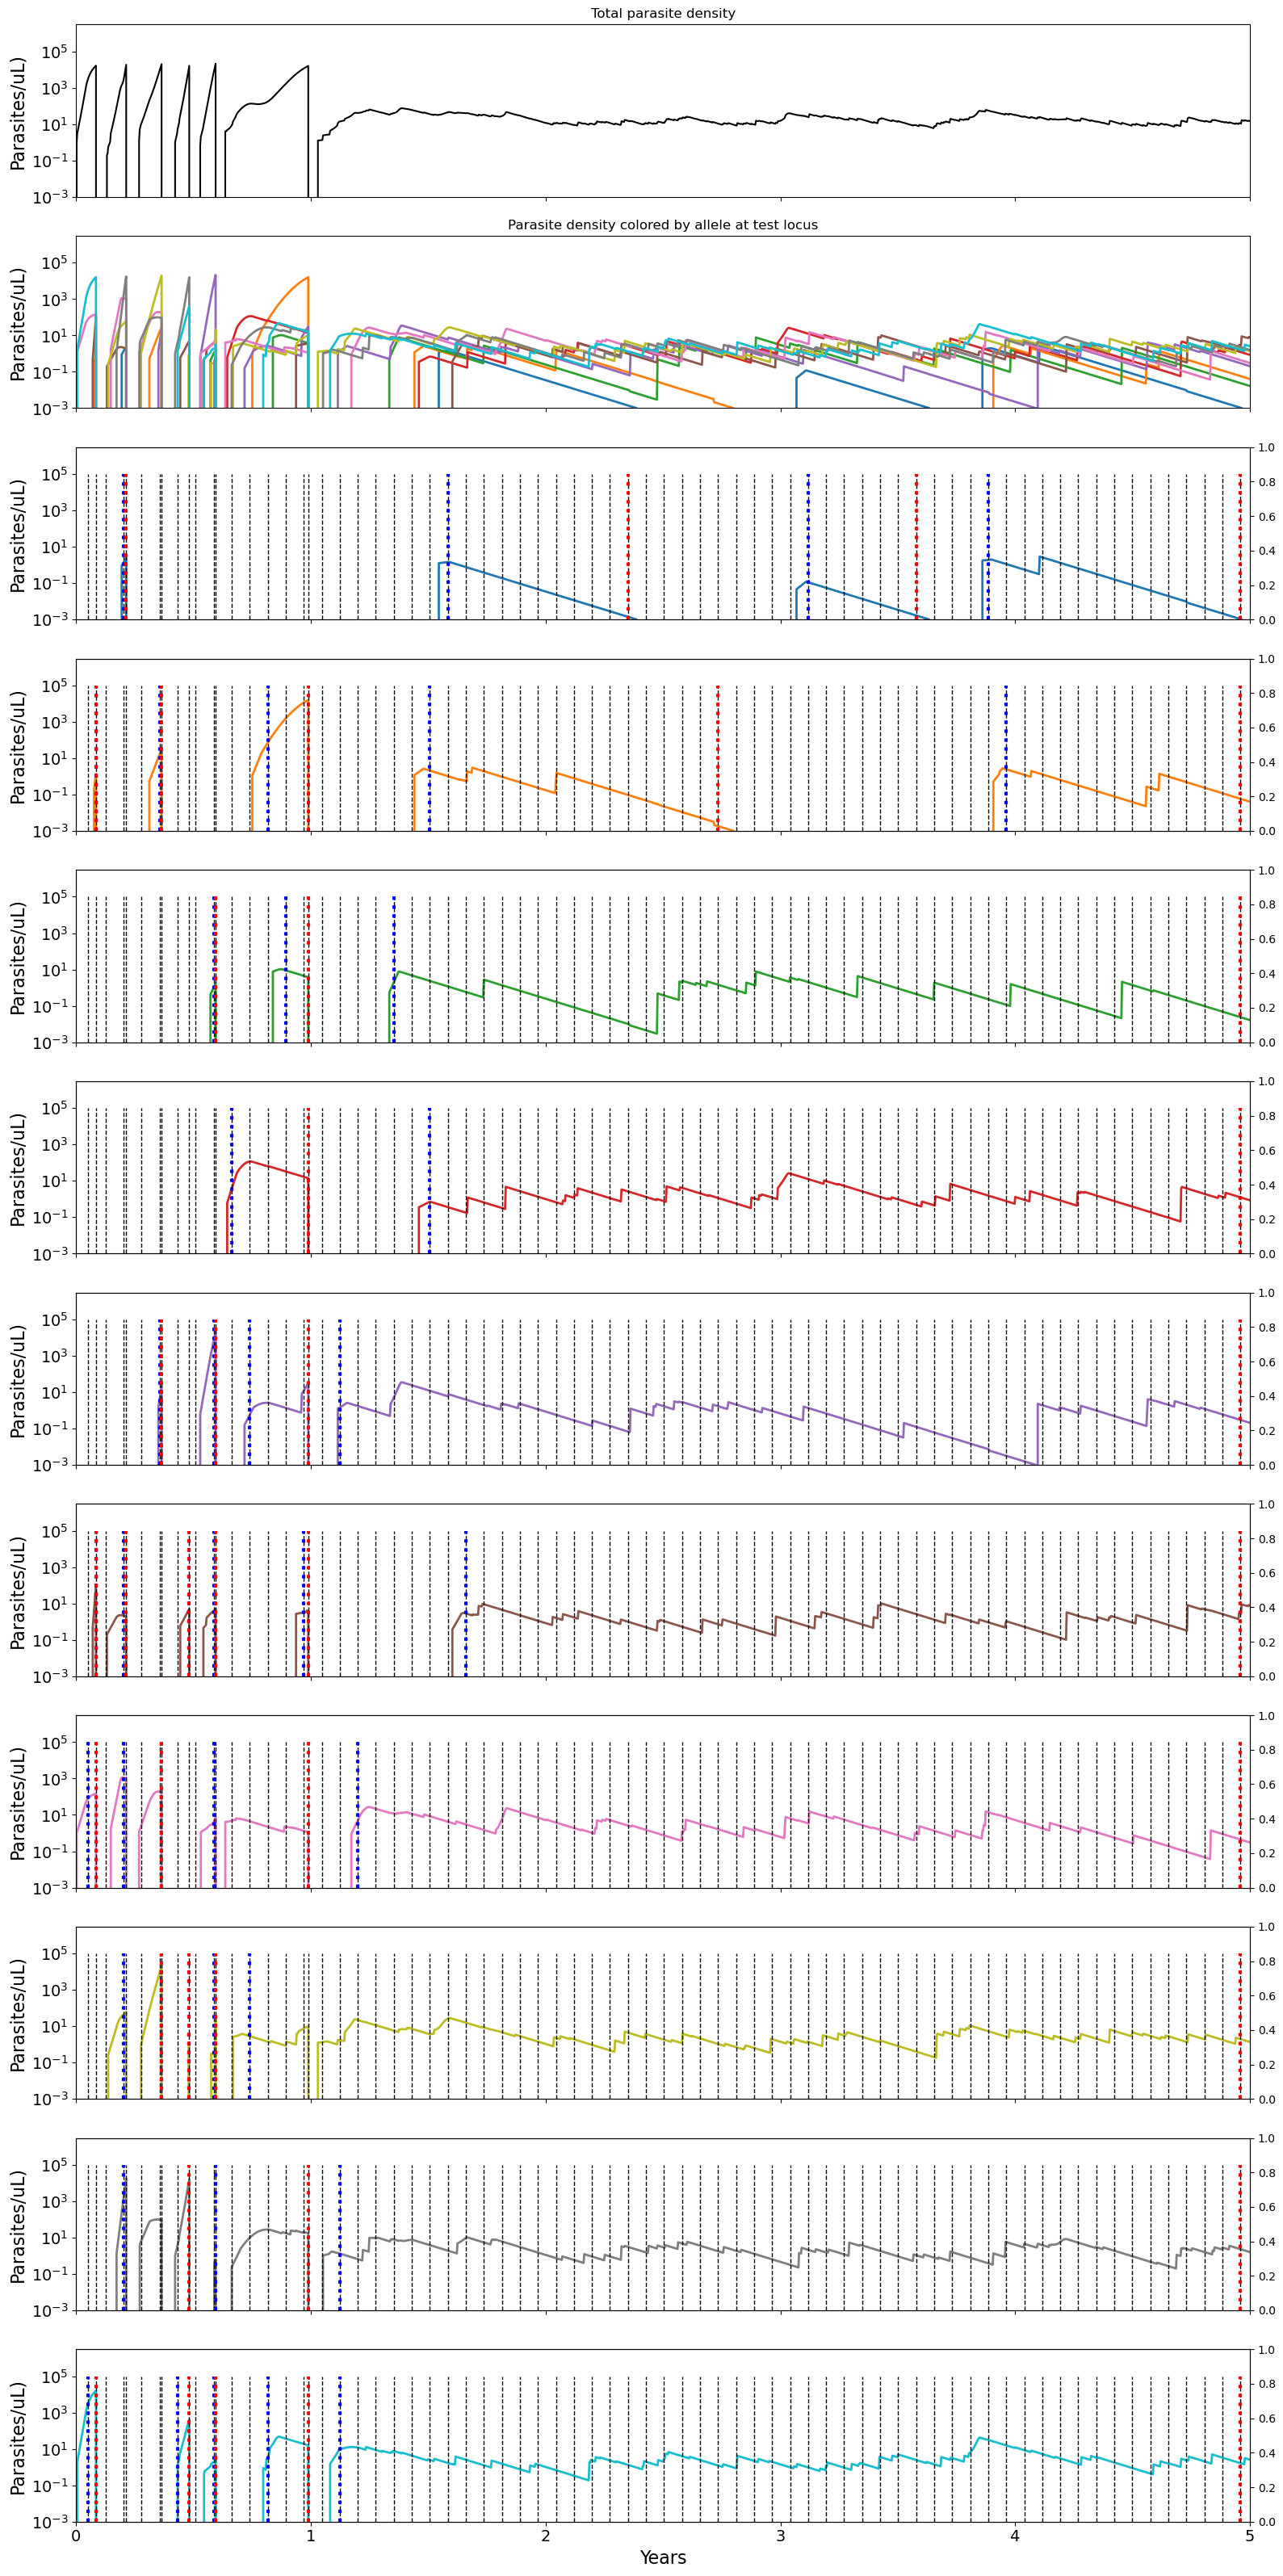

In [6]:
colors = {0:"tab:blue", 1:"tab:orange", 2:"tab:green", 3:"tab:red", 4:"tab:purple", 5:"tab:brown", 6:"tab:pink",7:"tab:olive",8:"tab:grey",9:"tab:cyan"}

fig, ax = plt.subplots(nrows=12, sharey=True, sharex=True, tight_layout=True, figsize=(16,32))
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_yscale('log')
ax[0].plot(np.arange(y*365)/365, pmatrix[-1,:,:].sum(axis=0),color="black")
for strain in np.arange(10):
    iStrain = pmatrix[-1,strain,:]
    if np.sum(iStrain) > 1:
        ax[1].plot(np.arange(y*365)/365, iStrain, linewidth=2,color=colors[strain])
ax[0].set_ylim(0.001,3000000)
ax[0].set_xlim(0,5)
#fig.suptitle('person ' + str(i),fontsize=18)
ax[11].set_xlabel('Years',fontsize=16)
ax[0].set_ylabel('Parasites/uL)',fontsize=16)
ax[0].set_title('Total parasite density')
ax[1].set_title('Parasite density colored by allele at test locus')
ax[1].set_ylabel('Parasites/uL)',fontsize=16)
for row in range(2,12):
    ax1 = ax[row].twinx()
    starts,ends, times = get_times_since(5,row-2,pmatrix,visits=visits)
    #print(starts)
    #print(ends)
    #print(times)
    ends = np.asarray(ends)
    starts = np.asarray(starts)
    mins = starts[1:]-times[1:]
    #print(mins)
    ax[row].tick_params(axis='both', which='major', labelsize=14)
    ax[row].set_ylabel('Parasites/uL)',fontsize=16)
    other = [strain for strain in range(0,10) if strain != row-2]
    ax[row].plot(np.arange(y*365)/365, pmatrix[-1,row-2,:],linewidth=2,color=colors[row-2])
    #ax1.plot(np.arange(y*365)/365,imatrix[-1,row-2,:],linewidth=2,color=colors[row-2],linestyle="dotted")
    ax[row].vlines(x=np.asarray(visits)/365,ymin=0.001,ymax=100000,color="black",linestyle="dashed",linewidth=1)
    ax[row].vlines(x=starts/365,ymin=0.001,ymax=100000,color="blue",linewidth=3,linestyle="dotted")
    ax[row].vlines(x=ends/365,ymin=0.001,ymax=100000,color="red",linewidth=3,linestyle="dotted")

    #for end,start in zip(mins,starts[1:]):
     #   ax[row].hlines(y=100000,xmin=end/365,xmax=start/365, color="blue")

In [7]:
def get_max_pdensity(pmatrix,loci,allele,window,visits):
    '''
    Returns maximum parasite density in a given time_window.
    '''
    visits = np.asarray(visits)
    visited = visits[(visits >= window[0]) & (visits <= window[1])]
    pdensities = pmatrix[loci,allele,visited]
    maxima = max(pdensities)
    time = np.argmax(pdensities)
    peaktime = visited[time]
    return maxima,peaktime

def get_symptomatic(time,malaria):
    if time in malaria:
        return 1
    else:
        return 0

def get_infections(pmatrix,visits):
    '''
    Returns estimated start times of infections.
    '''
    values = pmatrix[:,:,visits]
    signed = np.sign(values)
    shifted = np.roll(signed,1,2)
    test = signed - shifted
    test[test == -1] = 0
    crossAlleles = np.sum(test,axis=1)
    crossLoci = np.amax(crossAlleles,axis=0)
    infects = []
    for t, number in zip(visits,crossLoci):
        infects.extend(np.repeat(t,number))
    return np.asarray(infects)

def measure_person(pmatrix,visits,malaria,personID=None):
    nLoci,nAlleles,days=pmatrix.shape
    infectT = get_infections(pmatrix,visits)
    dfs = []
    for locus in range(nLoci):
        for allele in range(nAlleles):
            starts,ends,sinceExp = get_times_since(locus,allele,pmatrix,visits)
            if len(starts):
                infectN = [len(infectT[infectT<start]) for start in starts]
                peaks = [get_max_pdensity(pmatrix,locus,allele,[start,end],visits) for start,end in zip(starts,ends)]
                maxP = np.log10(np.asarray([pdens for pdens,time in peaks]))
                times = [time for pdens,time in peaks]
                shifted = np.roll(maxP,1)
                symps = [get_symptomatic(time,malaria) for time in times]
                deltaPdens = maxP-shifted
                deltaPdens[0] = np.nan
                df = pd.DataFrame({'locus':locus,'allele':allele,'infectionNumber':infectN,'age':starts,'maxPdens':maxP,'deltaPdens':deltaPdens,'daysSinceExp':sinceExp,'exposureNumber':np.arange(len(starts)),'symptomatic':symps})
                dfs.append(df)
    DF = pd.concat(dfs).reset_index(drop=True)
    if personID is not None:
        DF['person'] = personID
    return DF

def measure_cohort(all_parasites,all_malaria):
    nPeople,nLoci,nAlleles,days = all_parasites.shape
    y = int(days/365)
    all_visits = [pc.get_visits(all_malaria[person],28,y) for person in range(n_people)]
    dfs = [measure_person(all_parasites[person,...],visits,all_malaria[person],person) for person,visits in zip(range(n_people),all_visits)]
    df = pd.concat(dfs).reset_index(drop=True)
    return df
    

In [8]:
exp_df = measure_cohort(all_parasites,all_malaria)

In [9]:
exp_df['seen'] = np.where(exp_df['exposureNumber']==0,0,1)
exp_df['ctrl'] = np.where(exp_df['locus']==0,1,0)
exp_df['test'] = np.where(exp_df['locus']!=0,1,0)
exp_df['locus'] = exp_df['locus'].astype('str')
exp_df['person'] = exp_df['person'].astype('str')
exp_df['logInfectionNumber'] = np.log(exp_df['infectionNumber']+1)
exp_df['YsinceExp'] = exp_df['daysSinceExp']/365

In [10]:
exp_df.head()

,locus,allele,infectionNumber,age,maxPdens,deltaPdens,daysSinceExp,exposureNumber,symptomatic,person,seen,ctrl,test,logInfectionNumber,YsinceExp
0,0,0,54,1215,0.368218,NaN,NaN,0,0,0,0,1,0,4.007333,NaN
1,0,1,12,151,0.581199,NaN,NaN,0,0,0,0,1,0,2.564949,NaN
2,0,1,30,403,0.935782,0.354583,238.0,1,0,0,1,1,0,3.433987,0.652055
3,0,1,56,1271,-0.306167,-1.241949,724.0,2,0,0,1,1,0,4.043051,1.983562
4,0,2,35,515,-0.904614,NaN,NaN,0,0,0,0,1,0,3.583519,NaN


## Use DF to explore relationships between seen, unseen, pdens,infectionNumber,age

#### Max Pdens

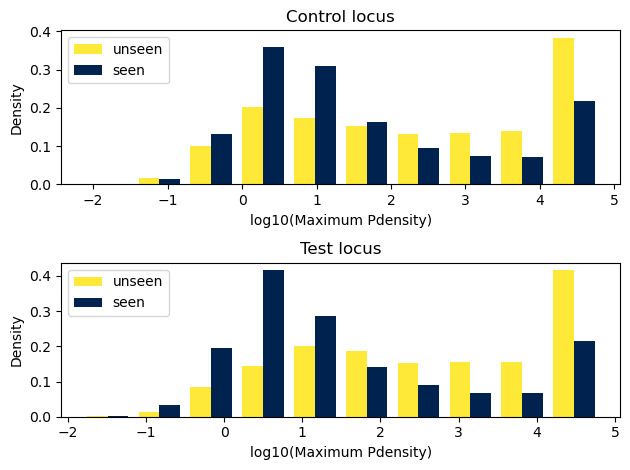

In [11]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.cividis(np.flip(np.linspace(0,1,2))))
fig,ax=plt.subplots(nrows=2,tight_layout=True)
for i,lab in zip(['0','1'],['Control locus','Test locus']):
    filt = exp_df.loc[exp_df.locus==i,:].sort_values(by='exposureNumber')
    ax[int(i)].set_title(lab)
    values = [filt.loc[filt.exposureNumber==0,'maxPdens'],filt.loc[filt.exposureNumber!=0,'maxPdens']]
    ax[int(i)].hist(values,density=True,label=['unseen','seen'])
    ax[int(i)].legend()
    ax[int(i)].set_xlabel('log10(Maximum Pdensity)')
    ax[int(i)].set_ylabel('Density')
#fig.savefig('figs/pdensHist_seenVunseen.pdf',bbox_inches='tight')

/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


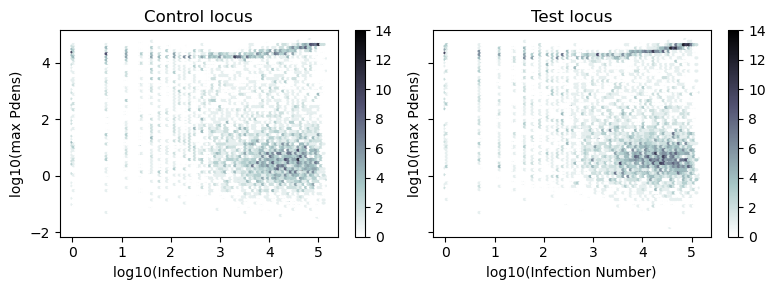

In [12]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.cividis(np.flip(np.linspace(0,1,1))))


fig,ax = plt.subplots(ncols=2,tight_layout=True,sharex=True,sharey=True, figsize=(8,3))
norm = plt.Normalize()
for i,lab in zip(['0','1'],['Control locus','Test locus']):
    ax[int(i)].set_title(lab)
    filt = exp_df.loc[exp_df.locus==i,:].sort_values(by='infectionNumber')
    hexed = ax[int(i)].hexbin(np.log(filt.infectionNumber),filt.maxPdens,cmap='bone_r',norm=norm)
    ax[int(i)].set_xlabel('log10(Infection Number)')
    ax[int(i)].set_ylabel('log10(max Pdens)')
    fig.colorbar(hexed, ax = ax[int(i)])

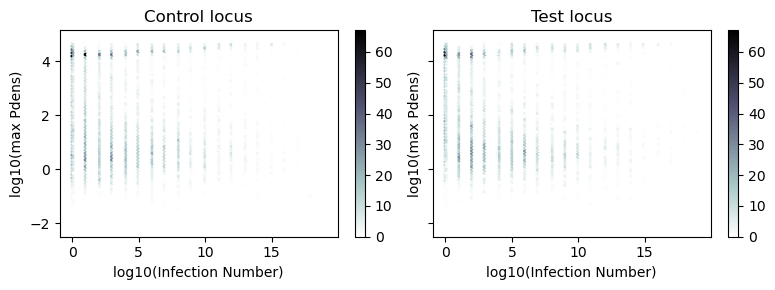

In [23]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.cividis(np.flip(np.linspace(0,1,1))))


fig,ax = plt.subplots(ncols=2,tight_layout=True,sharex=True,sharey=True, figsize=(8,3))
norm = plt.Normalize()
for i,lab in zip(['0','1'],['Control locus','Test locus']):
    ax[int(i)].set_title(lab)
    filt = exp_df.loc[exp_df.locus==i,:].sort_values(by='infectionNumber')
    hexed = ax[int(i)].hexbin(filt.exposureNumber,filt.maxPdens,cmap='bone_r',norm=norm)
    ax[int(i)].set_xlabel('log10(Infection Number)')
    ax[int(i)].set_ylabel('log10(max Pdens)')
    fig.colorbar(hexed, ax = ax[int(i)])

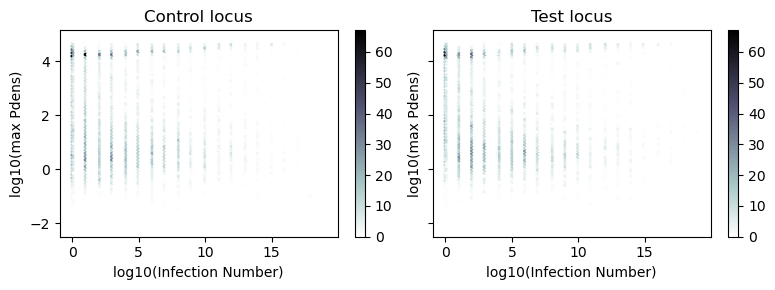

In [29]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.cividis(np.flip(np.linspace(0,1,1))))


fig,ax = plt.subplots(ncols=2,tight_layout=True,sharex=True,sharey=True, figsize=(8,3))
norm = plt.Normalize()
for i,lab in zip(['0','1'],['Control locus','Test locus']):
    ax[int(i)].set_title(lab)
    filt = exp_df.loc[exp_df.locus==i,:].sort_values(by='infectionNumber')
    hexed = ax[int(i)].hexbin(filt.exposureNumber,filt.maxPdens,cmap='bone_r',norm=norm)
    ax[int(i)].set_xlabel('log10(Infection Number)')
    ax[int(i)].set_ylabel('log10(max Pdens)')
    fig.colorbar(hexed, ax = ax[int(i)])

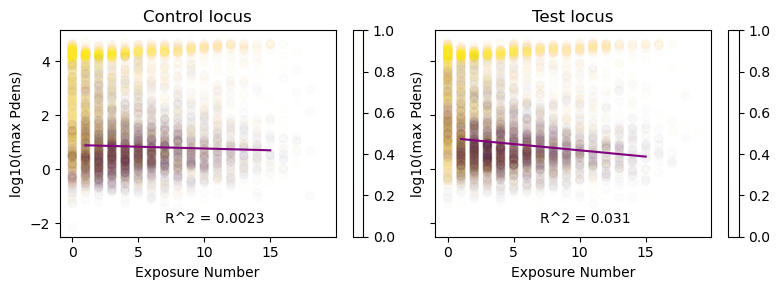

In [95]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.cividis(np.flip(np.linspace(0,1,1))))

fig,ax = plt.subplots(ncols=2,tight_layout=True,sharex=True,sharey=True, figsize=(8,3))
norm = plt.Normalize()
for i,lab in zip(['0','1'],['Control locus','Test locus']):

    ax[int(i)].set_title(lab)
    filt = exp_df.loc[exp_df.locus==i,:].sort_values(by='infectionNumber')
    slope, intercept, r, p_value, std_err = st.linregress(filt.loc[(filt.symptomatic==0),'exposureNumber'],filt.loc[(filt.symptomatic==0),'maxPdens'])
    hexed = ax[int(i)].scatter(filt.exposureNumber,filt.maxPdens,c=filt.symptomatic,norm=norm,alpha=0.01)
    x = np.asarray(range(0,15))+1
    #slope, intercept, r, p_value, std_err = st.linregress(np.log(filt.loc[(filt.exposureNumber!=0)&(filt.symptomatic==0),'exposureNumber']),filt.loc[(filt.exposureNumber!=0)&(filt.symptomatic==0),'maxPdens'])
    #hexed = ax[int(i)].scatter(np.log(filt.exposureNumber),filt.maxPdens,c=filt.symptomatic,norm=norm,alpha=0.01)
    #x = np.log(np.asarray(range(0,15))+1)
    y = (x*slope) + intercept
    ax[int(i)].plot(x,y,color='purple')
    ax[int(i)].text(7,-2, "R^2 = " + "{0:.2g}".format(r**2))
    ax[int(i)].set_xlabel('Exposure Number')
    ax[int(i)].set_ylabel('log10(max Pdens)')
    fig.colorbar(hexed, ax = ax[int(i)])

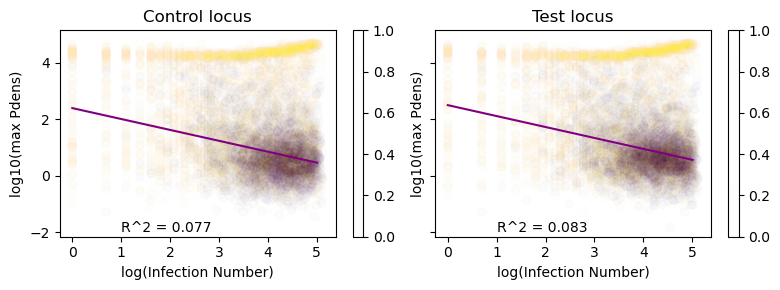

In [91]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.cividis(np.flip(np.linspace(0,1,1))))


fig,ax = plt.subplots(ncols=2,tight_layout=True,sharex=True,sharey=True, figsize=(8,3))
norm = plt.Normalize()
for i,lab in zip(['0','1'],['Control locus','Test locus']):
    ax[int(i)].set_title(lab)
    filt = exp_df.loc[exp_df.locus==i,:].sort_values(by='infectionNumber')
    slope, intercept, r, p_value, std_err = st.linregress(np.log(filt.loc[(filt.infectionNumber!=0)&(filt.symptomatic==0),'infectionNumber']),filt.loc[(filt.infectionNumber!=0)&(filt.symptomatic==0),'maxPdens'])
    hexed = ax[int(i)].scatter(np.log(filt.infectionNumber),filt.maxPdens,c=filt.symptomatic,norm=norm,alpha=0.01)
    x = np.log(np.asarray(range(0,150))+1)
    #slope, intercept, r, p_value, std_err = st.linregress(filt.loc[(filt.symptomatic==0),'infectionNumber'],filt.loc[(filt.symptomatic==0),'maxPdens'])
    #hexed = ax[int(i)].scatter(filt.infectionNumber,filt.maxPdens,c=filt.symptomatic,norm=norm,alpha=0.01)
    #x = np.asarray(range(0,150))+1
    y = (x*slope) + intercept
    ax[int(i)].plot(x,y,color='purple')
    ax[int(i)].text(1,-2, "R^2 = " + "{0:.2g}".format(r**2))
    ax[int(i)].set_xlabel('log(Infection Number)')
    ax[int(i)].set_ylabel('log10(max Pdens)')
    fig.colorbar(hexed, ax = ax[int(i)])

Text(0, 0.5, 'Exposure Number')

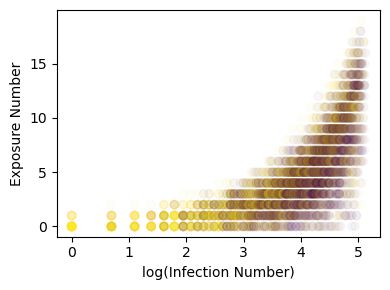

In [96]:
fig,ax = plt.subplots(tight_layout=True,sharex=True,sharey=True, figsize=(4,3))
ax.scatter(np.log(filt.infectionNumber),filt.exposureNumber,c=filt.symptomatic,alpha=0.03)
ax.set_xlabel('log(Infection Number)')
ax.set_ylabel('Exposure Number')

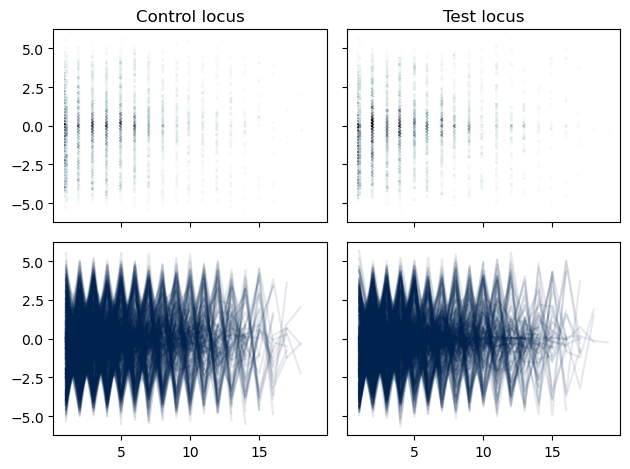

In [26]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.cividis(np.flip(np.linspace(0,1,1))))


fig,ax = plt.subplots(ncols=2,nrows=2,tight_layout=True,sharex=True,sharey=True)
norm = plt.Normalize()
for i,lab in zip(['0','1'],['Control locus','Test locus']):
    ax[0,int(i)].set_title(lab)
    filt = exp_df.loc[exp_df.locus==i,:].sort_values(by='exposureNumber')
    hexed = ax[0,int(i)].hexbin(filt.exposureNumber,filt.deltaPdens,cmap='bone_r',norm=norm)
    for person in range(100):
        person = str(person)
        for allele in range(max(a)):
            ax[1,int(i)].plot(filt.loc[(filt.person==person)&(filt.allele==allele),'exposureNumber'].values,filt.loc[(filt.person==person)&(filt.allele==allele),'deltaPdens'].values,alpha=0.1)
#fig.colorbar(anchor=(1.5,1.05),panchor=False,use_gridspec=True)

/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6709: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6710: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


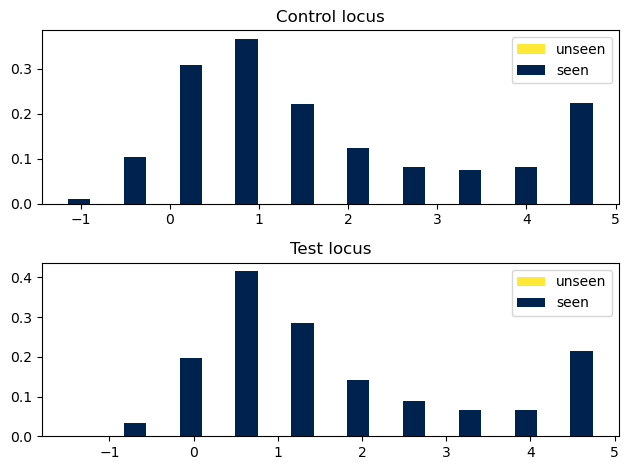

In [14]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.cividis(np.flip(np.linspace(0,1,2))))
fig,ax=plt.subplots(nrows=2,tight_layout=True)
for i,lab in zip(['0','1'],['Control locus','Test locus']):
    filt = exp_df.loc[exp_df.locus==i,:].sort_values(by='exposureNumber')
    ax[int(i)].set_title(lab)
    values = [filt.loc[filt.exposureNumber==0,'deltaPdens'],filt.loc[filt.exposureNumber!=0,'maxPdens']]
    ax[int(i)].hist(values,density=True,label=['unseen','seen'])
    ax[int(i)].legend()

KeyboardInterrupt: 

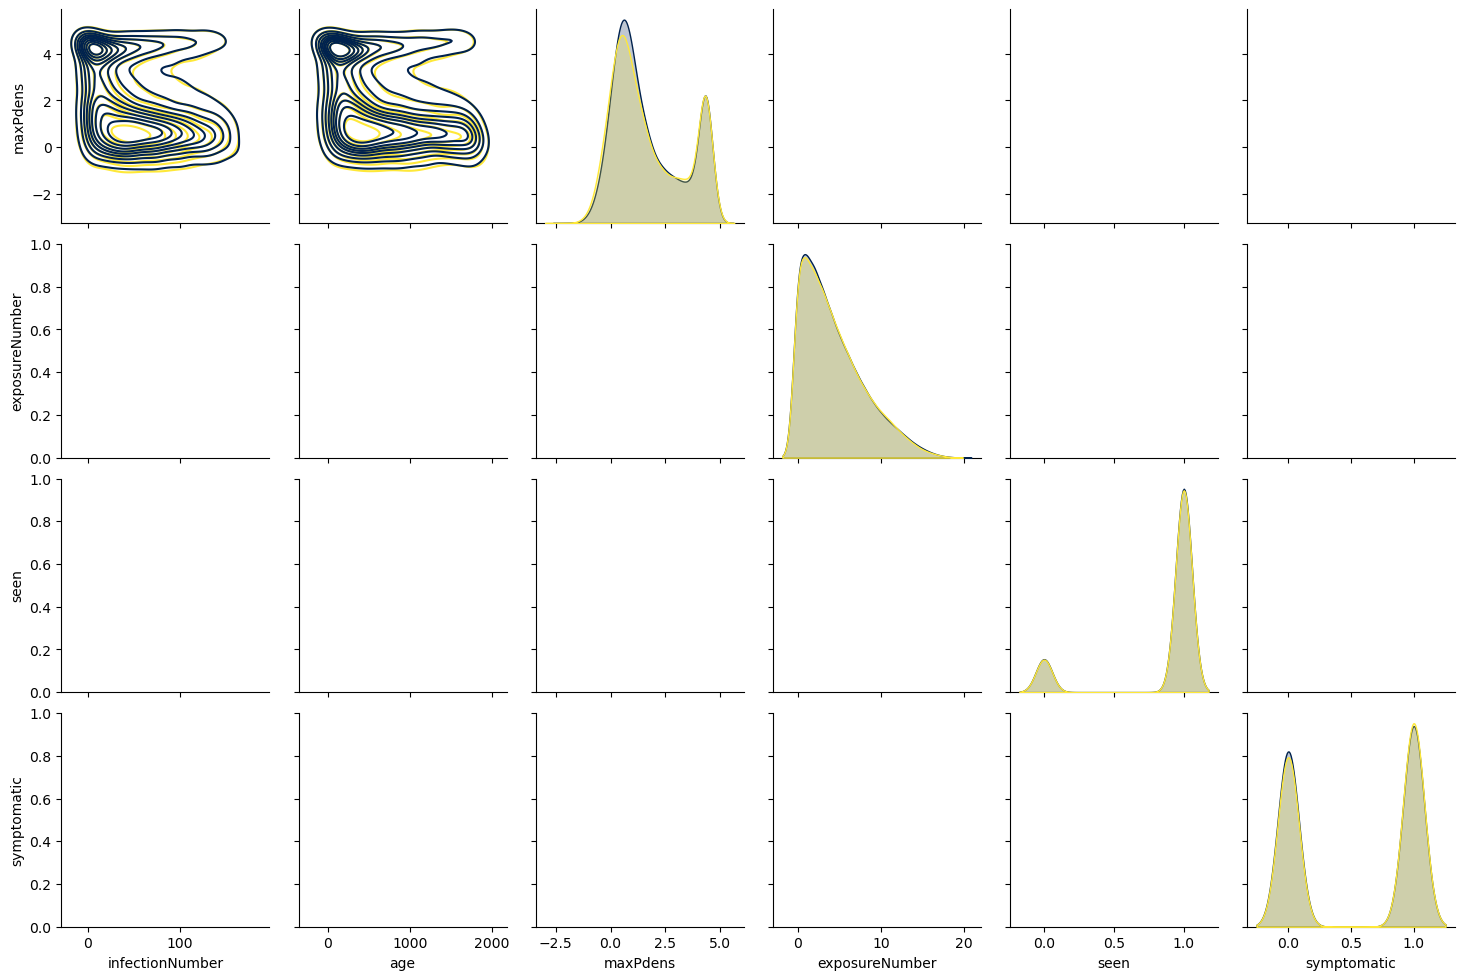

In [15]:
pplt_all = sns.pairplot(exp_df.loc[(exp_df.locus=='0') | (exp_df.locus=='1'),:],x_vars=['infectionNumber','age','maxPdens','exposureNumber','seen','symptomatic'],y_vars=['maxPdens','exposureNumber','seen','symptomatic'],hue='locus',kind='kde')
#pplt_all.savefig('figs/pairplot_expdf.pdf',bbox_inches='tight',dpi=300)

In [ ]:
for y in range(1,6):
    days = y*365
    filt = exp_df.loc[exp_df.age<days,:]
    pplt_all = sns.pairplot(filt.loc[(filt.locus=='0') | (filt.locus=='1'),:],x_vars=['infectionNumber','age','maxPdens','exposureNumber','seen','symptomatic'],y_vars=['maxPdens','exposureNumber','seen','symptomatic'],hue='locus',kind='kde')
    pplt_all.savefig('figs/pairplot_expdf_y'+str(y)+'.pdf',bbox_inches='tight',dpi=300)

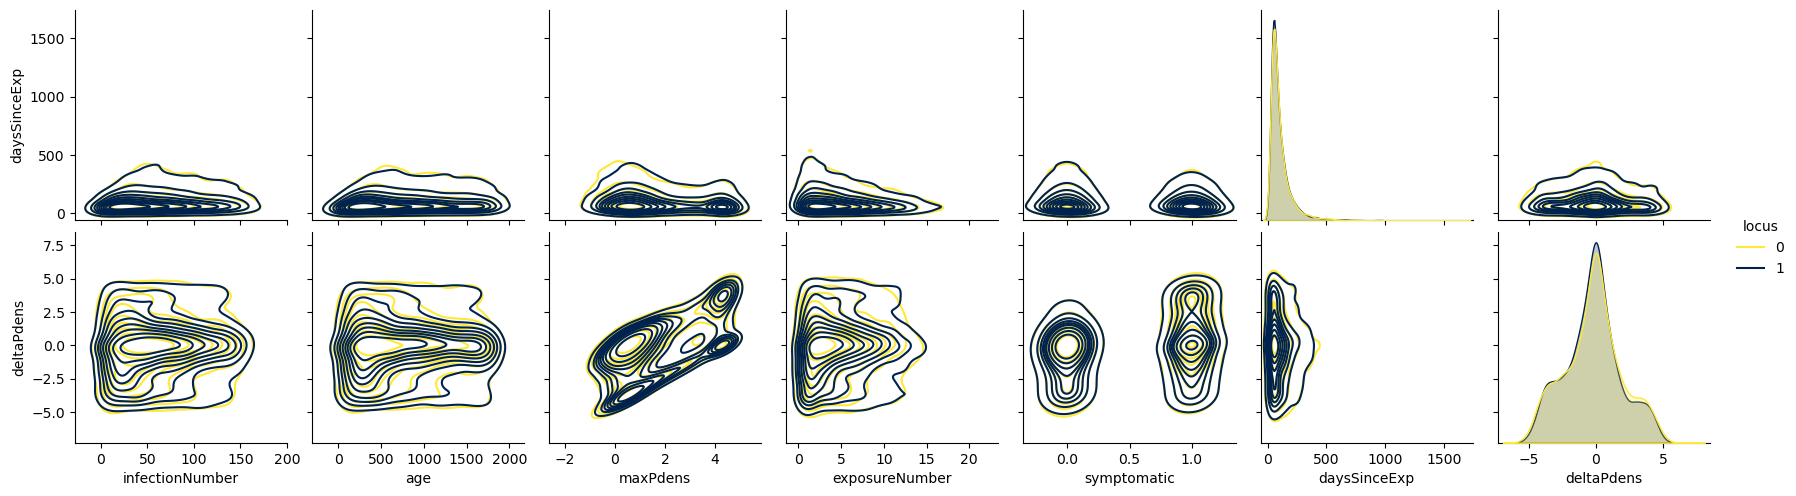

In [131]:
pplt_sinceExp = sns.pairplot(exp_df.loc[(exp_df.locus=='0') | (exp_df.locus=='1'),:],x_vars=['infectionNumber','age','maxPdens','exposureNumber','symptomatic','daysSinceExp','deltaPdens'],y_vars=['daysSinceExp','deltaPdens'],hue='locus',kind='kde')
#pplt_sinceExp.savefig('figs/pairplot_sinceExp.pdf',bbox_inches='tight',dpi=300)

In [ ]:
for y in range(1,6):
    days = y*365
    filt = exp_df.loc[exp_df.age<days,:]
    pplt_sinceExp = sns.pairplot(filt.loc[(filt.locus=='0') | (filt.locus=='1'),:],x_vars=['infectionNumber','age','maxPdens','exposureNumber','symptomatic','daysSinceExp','deltaPdens'],y_vars=['daysSinceExp','deltaPdens'],hue='locus',kind='kde')
    pplt_sinceExp.savefig('figs/pairplot_sinceExp+y'+str(y)+'.pdf',bbox_inches='tight',dpi=300)

In [16]:
predictors = ['seen','logInfectionNumber']
X = exp_df[predictors]
Y = exp_df['maxPdens']

# Initialise and fit model
lm = LinearRegression()
model = lm.fit(X, Y)

In [17]:
model.intercept_

3.156969029216646

In [18]:
model.coef_

array([-0.25226951, -0.34036234])

In [19]:
exp_df.seen

0        0
1        0
2        1
3        1
4        0
        ..
42538    1
42539    1
42540    1
42541    1
42542    1
Name: seen, Length: 42543, dtype: int64

In [31]:
filt = exp_df.loc[exp_df.seen==1,:]
g = filt.groupby(by=['locus','person','allele']).groups
for i, key in enumerate(g.keys()):
    filt.loc[g[key],'group'] = str(i)

/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_99656/584167183.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt.loc[g[key],'group'] = str(i)


In [33]:
model_rcoef = sm.MixedLM.from_formula(formula='maxPdens ~ logInfectionNumber + symptomatic + exposureNumber+ YsinceExp:locus', data=filt,groups = 'group',exog_re='group').fit()
summary = model_rcoef.summary()
print(summary.tables[1])
model_rcoef.llf

                     Coef. Std.Err.        z  P>|z|  [0.025  0.975]
Intercept            1.878    0.047   39.632  0.000   1.785   1.971
logInfectionNumber  -0.326    0.015  -21.414  0.000  -0.356  -0.296
symptomatic          1.306    0.015   87.675  0.000   1.277   1.336
exposureNumber       0.056    0.004   15.769  0.000   0.049   0.064
YsinceExp:locus[0]  -0.040    0.047   -0.857  0.392  -0.132   0.052
YsinceExp:locus[1]   0.187    0.047    3.959  0.000   0.095   0.280
YsinceExp:locus[2]   0.228    0.047    4.874  0.000   0.136   0.320
YsinceExp:locus[3]   0.273    0.047    5.858  0.000   0.182   0.364
YsinceExp:locus[4]   0.229    0.047    4.884  0.000   0.137   0.321
YsinceExp:locus[5]   0.187    0.046    4.087  0.000   0.098   0.277
group Var            0.098    0.005                                


-62854.13943905043

(array([1.000e+00, 1.000e+00, 4.760e+02, 3.409e+03, 7.066e+03, 1.138e+04,
        5.656e+03, 5.491e+03, 2.670e+03, 8.200e+01]),
 array([-5.27552897, -4.36127923, -3.4470295 , -2.53277976, -1.61853002,
        -0.70428028,  0.20996945,  1.12421919,  2.03846893,  2.95271866,
         3.8669684 ]),
 <BarContainer object of 10 artists>)

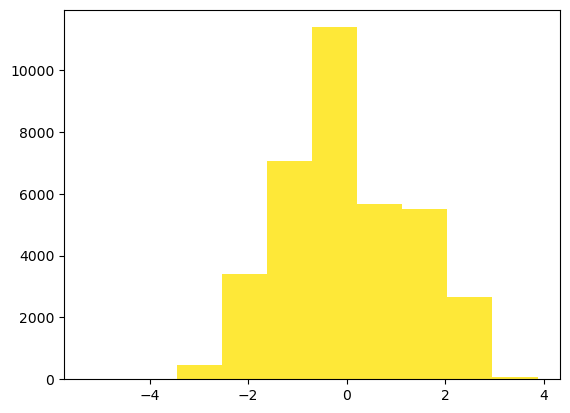

In [137]:
plt.hist(model_rcoef.resid)

In [109]:
model_rint = sm.MixedLM.from_formula(formula='maxPdens ~ logInfectionNumber + symptomatic + YsinceExp:locus', data=filt,groups = 'group').fit()
summary = model_rint.summary()
print(summary.tables[1])
model_rint.llf

                     Coef. Std.Err.        z  P>|z|  [0.025  0.975]
Intercept            2.382    0.048   50.136  0.000   2.289   2.475
logInfectionNumber  -0.318    0.010  -32.451  0.000  -0.337  -0.299
symptomatic          0.476    0.024   19.948  0.000   0.429   0.523
YsinceExp:locus[0]  -0.275    0.049   -5.588  0.000  -0.371  -0.178
YsinceExp:locus[1]  -0.075    0.053   -1.425  0.154  -0.178   0.028
YsinceExp:locus[2]   0.001    0.050    0.021  0.984  -0.098   0.100
YsinceExp:locus[3]   0.025    0.051    0.498  0.618  -0.074   0.125
YsinceExp:locus[4]   0.050    0.051    0.971  0.332  -0.051   0.150
YsinceExp:locus[5]  -0.040    0.052   -0.773  0.440  -0.141   0.061
group Var            0.215    0.007                                


-65396.61159997489

In [62]:
exp_df.loc[exp_df.symptomatic==0,:]

,locus,allele,infectionNumber,age,maxPdens,deltaPdens,daysSinceExp,exposureNumber,symptomatic,person,seen,ctrl,test,logInfectionNumber,YsinceExp
15,0,2,149,1771,0.113618,-3.572248,538.0,8,0,0,1,1,0,5.010635,1.473973
20,0,3,144,1743,2.523514,-1.695087,39.0,4,0,0,1,1,0,4.976734,0.106849
27,0,4,144,1743,1.496766,0.632901,186.0,6,0,0,1,1,0,4.976734,0.509589
51,0,6,149,1771,0.797606,0.448283,67.0,12,0,0,1,1,0,5.010635,0.183562
62,0,7,149,1771,1.436234,-0.806049,67.0,10,0,0,1,1,0,5.010635,0.183562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42097,5,5,28,544,1.495601,-2.992002,459.0,1,0,99,1,0,1,3.367296,1.257534
42101,5,6,13,208,1.886696,1.677564,46.0,3,0,99,1,0,1,2.639057,0.126027
42104,5,7,13,208,3.977345,-0.095151,92.0,2,0,99,1,0,1,2.639057,0.252055
42106,5,8,13,208,1.503661,-0.351792,160.0,1,0,99,1,0,1,2.639057,0.438356


In [58]:
def plot_trajecs(pmatrix,imatrix,bites,locus,a,y,output=None):
    colors = {0:"tab:blue", 1:"tab:orange", 2:"tab:green", 3:"tab:red", 4:"tab:purple", 5:"tab:brown", 6:"tab:pink",7:"tab:olive",8:"tab:grey",9:"tab:cyan"}
    nLoci, nBites = bites.shape

    fig, ax = plt.subplots(nrows=12, sharey=True, sharex=True, tight_layout=True, figsize=(16,32))
    ax[0].tick_params(axis='both', which='major', labelsize=14)
    ax[1].tick_params(axis='both', which='major', labelsize=14)
    ax[0].set_yscale('log')
    ax[0].plot(np.arange(y*365)/365, pmatrix[locus,:,:].sum(axis=0),color="black")
    ax[0].plot(bites[0,:]/365,np.repeat(0.0005,nBites),'^',color='grey')

    for strain in np.arange(a[locus]):
        iStrain = pmatrix[locus,strain,:]
        if np.sum(iStrain) > 1:
            ax[1].plot(np.arange(y*365)/365, iStrain, linewidth=2,color=colors[strain])
    ax[1].plot(bites[0,:]/365,np.repeat(0.0005,nBites),'^',color='grey')
    ax[0].set_ylim(0.00028,3000000)
    ax[6].set_xlabel('Years',fontsize=16)
    ax[0].set_ylabel('Parasites/uL',fontsize=16)
    ax[0].set_title('Total parasite density')
    ax[1].set_title('Parasite density colored by allele at test locus')
    ax[1].set_ylabel('Parasites/uL',fontsize=16)
    for row in range(2,12):
        ax[row].tick_params(axis='both', which='major', labelsize=14)
        ax[row].set_ylabel('Parasites/uL',fontsize=16)
        other = [strain for strain in range(0,5) if strain != row-2]
        ax[row].plot(np.arange(y*365)/365, pmatrix[locus,row-2,:],linewidth=3,color=colors[row-2])
        Abites = bites[0,bites[locus]==row-2]
        ax[row].plot(Abites/365,np.repeat(0.0005,len(Abites)),'^',color='grey')


        #ax[row].vlines(x=np.asarray(visits)/365,ymin=0.001,ymax=100000,color="black",linestyle="dashed",linewidth=1)

        #for strain in other:
         #   ax[row].plot(np.arange(y*365)/365, all_parasites[i,-1,strain,:],linewidth=2,alpha=0.2,color=colors[strain])

        ax2 = ax[row].twinx()
        ax2.set_ylabel('Strain immunity',fontsize=16)
        ax2.plot(np.arange(y*365)/365, imatrix[locus,row-2,:],linewidth=1.5,color='black',linestyle='dashed')
       
    if output:
        fig.savefig('figs/trajec_'+output+'.pdf',bbox_inches='tight',dpi=300)

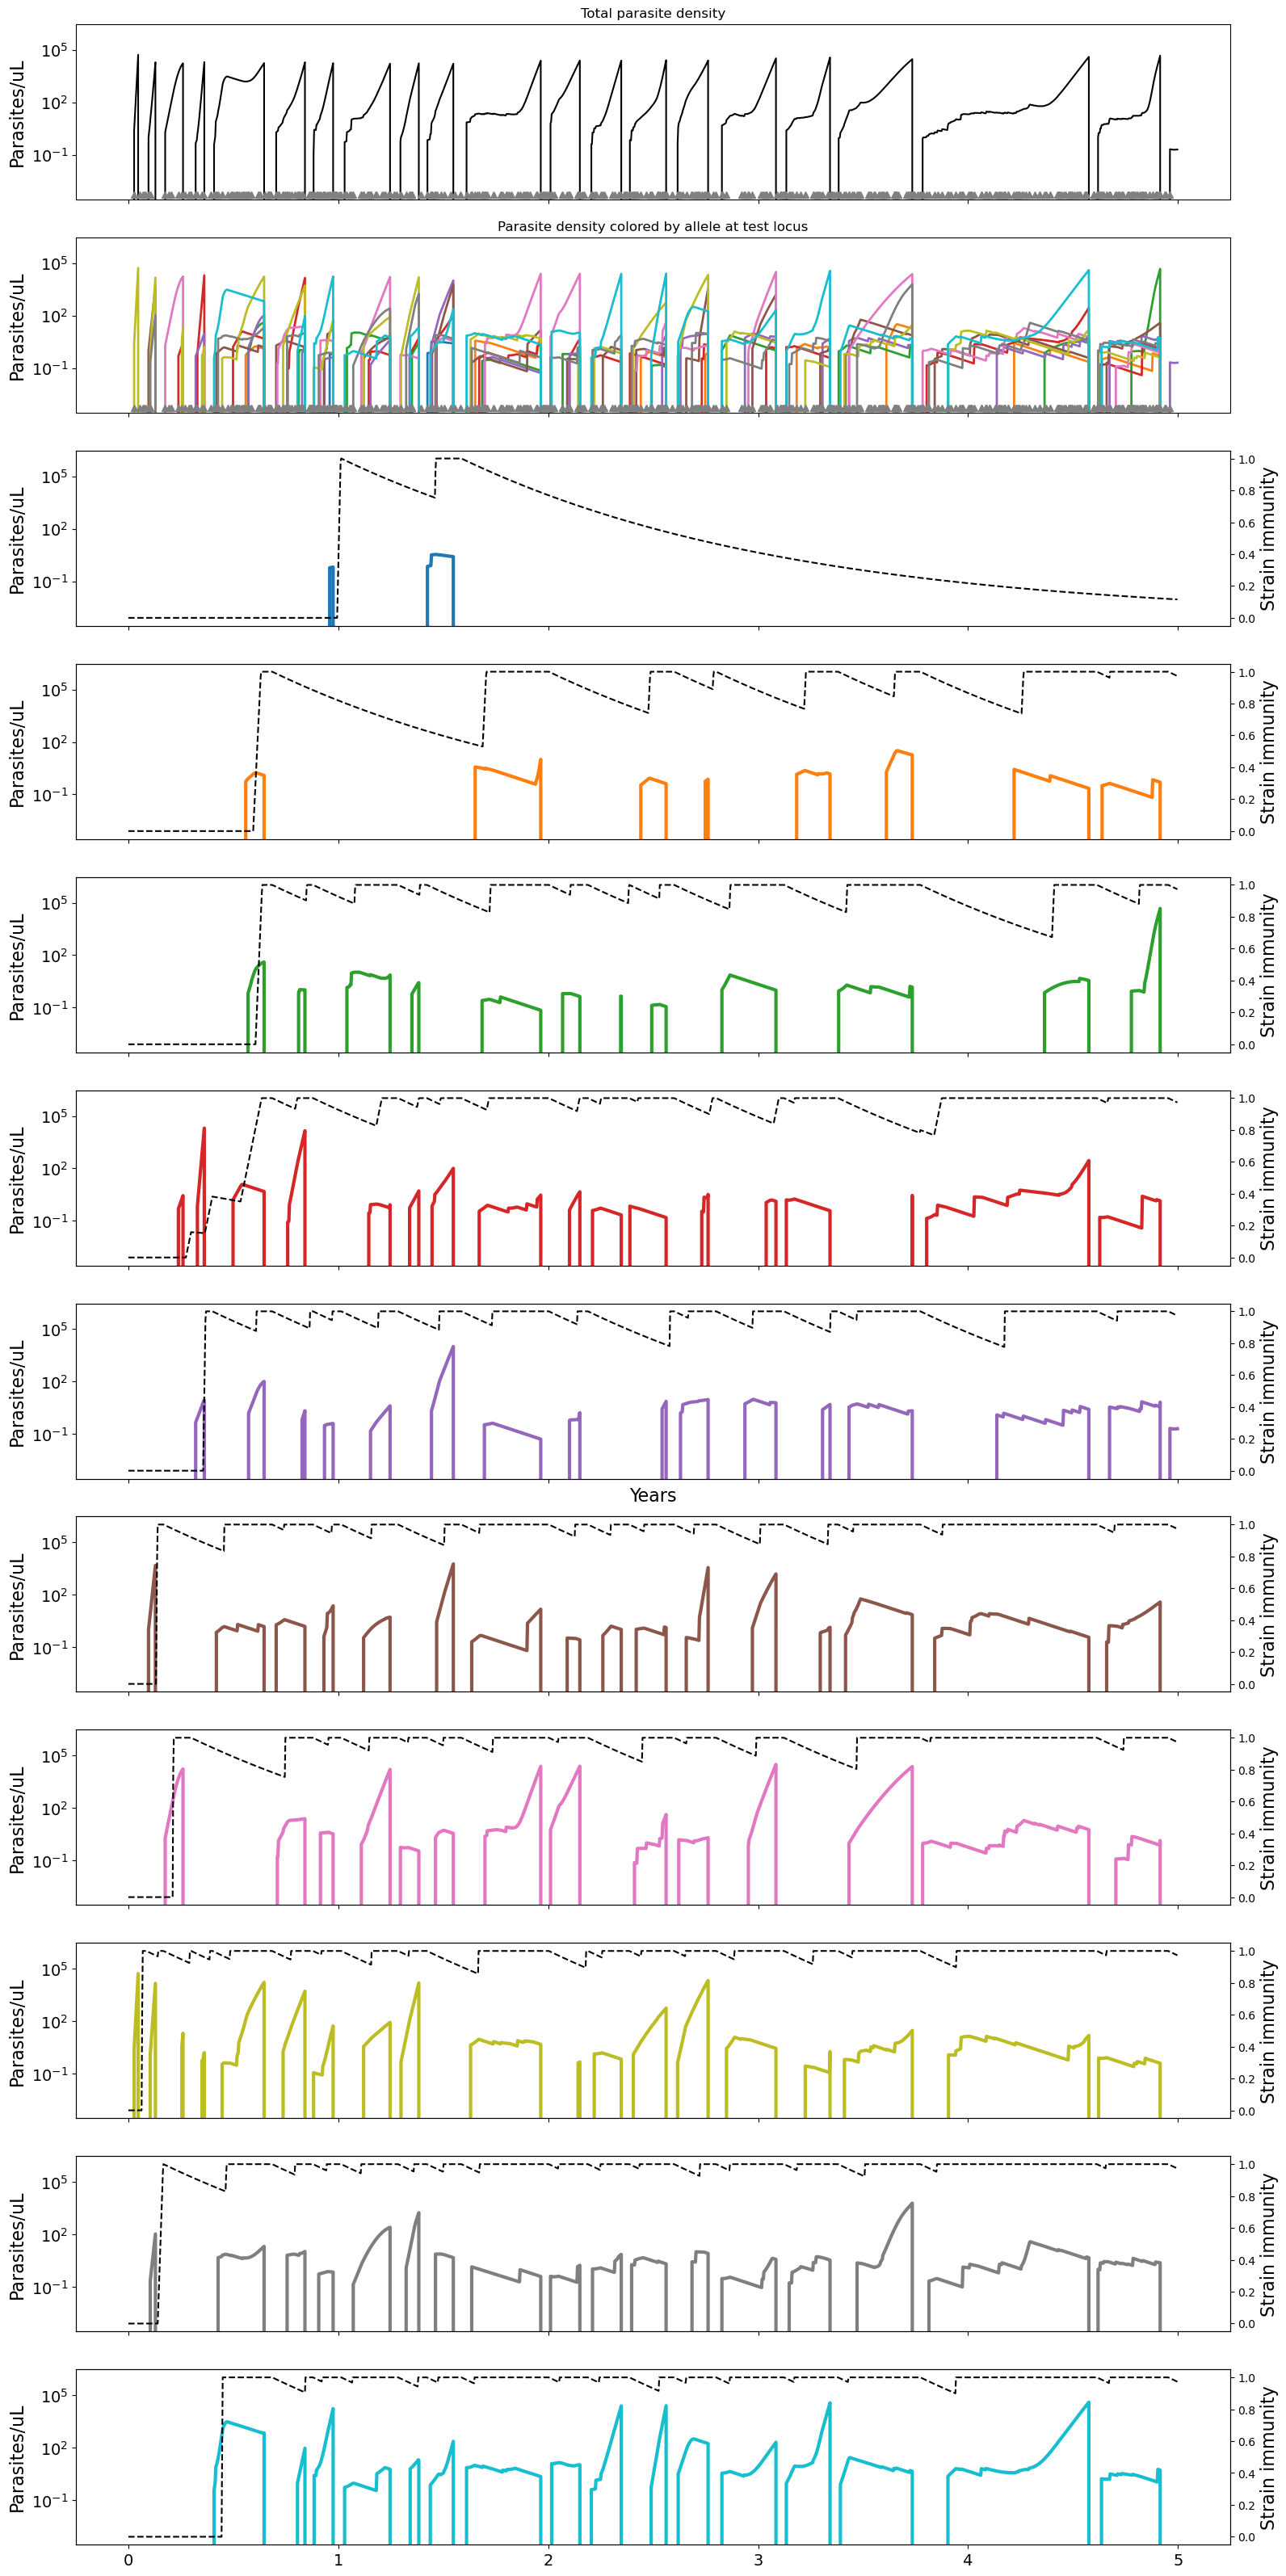

In [64]:
plot_trajecs(pmatrix,imatrix,bites,0,a,5,'non-antigenic')

In [ ]:
def getImmExp(a,locus,all_parasites,all_immunity,all_malaria):
    '''
    Returns Immunity & Time since exposure for a locus from a cohort of simulations.
    If all_in
    '''
    all_imm = []
    all_times= []
    for person in range(n_people):
        visits = pc.get_visits(all_malaria[person],28,y)
        infectmatrix=[]
        smatrix=[]
        for allele in range(a[locus]):
            starts,ends,times = get_times_since(locus,allele,all_parasites[person,...],visits)
            times_to_check = [visits[visits.index(start)-1] for start in starts]
            if len(times):
                immunity = all_immunity[person,locus,allele,times_to_check]
                all_imm.extend(immunity)
                all_times.extend(times)
    return all_imm, all_times

(-0.05, 1.05)

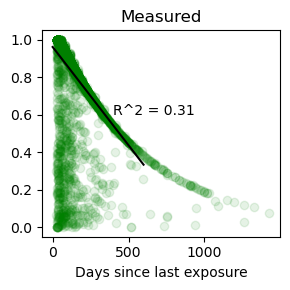

In [10]:
test_immM, test_timesM = getImmExp(a,5,all_parasites,all_immunity,all_malaria=all_malaria)
slope_mtest, intercept_mtest, r_mtest, p_mtest, se_mtest = st.linregress(test_timesM, test_immM)

x = np.arange(600)
y_mtest = (x*slope_mtest) + intercept_mtest

fig,ax = plt.subplots(tight_layout=True,figsize=(3,3))
ax.plot(test_timesM,test_immM, 'go', alpha=0.1)
ax.plot(x,y_mtest,color="black")
ax.text(400,0.6, "R^2 = " + "{0:.2g}".format(r_mtest**2))
ax.set_title("Measured")
ax.set_xlabel("Days since last exposure")
ax.set_ylim(-0.05,1.05)

So I have to write code to pull in max pdens, change in max pdens since last time you saw an allele, infection number, and exposure number, and allele number, and time since exposure. I think I have most of this. I need to explicitly get exposure number, and I have to write the damn code for infection number.